In [1]:
import numpy as np
from numpy import outer, trace, dot, pi, log, exp, sin, cos, sqrt
from scipy.linalg import eig, eigh, norm, svd, kron, expm, sqrtm
from scipy.stats import gaussian_kde, unitary_group
from scipy.optimize import minimize

import qutip as qp
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

import time
import random
from functools import reduce

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

import mpmath as mp
mp.dps = 250; mp.pretty = False

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [150]:
s0 = np.array([[1],
               [0]])
P0 = np.array([[1., 0.],
               [0., 0.]]) # |0><0|
P1 = np.array([[0., 0.],
               [0., 1.]]) # |1><1|
X = np.array([[0.,1.],
              [1.,0.]]) # X Pauli matrix
Y = np.array([[0.,-1.j],
              [1.j, 0.]]) # Y Pauli matrix
Z = np.array([[1., 0.],
              [0.,-1.]]) # Z Pauli matrix
I = np.array([[1.,0.],
              [0.,1.]]) # 2x2 identity matrix
H = (X + Z) / sqrt(2)
XX = kron(X, X)
YY = kron(Y, Y)
ZZ = kron(Z, Z)

In [3]:
swap = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1]])

cswap = reduce(kron, [P0, I, I]) + reduce(kron, [P1, swap])

In [4]:
def su2(parameters):
    
    c_11 =  exp(1j * (-parameters[1] - parameters[2])) * cos(parameters[0])
    c_12 = -exp(1j * (-parameters[1] + parameters[2])) * sin(parameters[0])
    c_21 =  exp(1j * ( parameters[1] - parameters[2])) * sin(parameters[0])
    c_22 =  exp(1j * ( parameters[1] + parameters[2])) * cos(parameters[0])
    operator = np.array([[c_11, c_12],
                         [c_21, c_22]])
    
    return operator


def su4(parameters):
    
    op_11 = su2([parameters[0], parameters[1], parameters[2]])
    op_12 = su2([parameters[3], parameters[4], parameters[5]])
    op_1 = kron(op_11, op_12)
    
    op_2 = expm(1j * (parameters[6]*XX + parameters[7]*YY + parameters[8]*ZZ))
    
    op_31 = su2([parameters[9], parameters[10], parameters[11]])
    op_32 = su2([parameters[12], parameters[13], parameters[14]])
    op_3 = kron(op_31, op_32)
    
    return op_3.dot(op_2).dot(op_1)

In [5]:
def fidelity(dm1, dm2):
    
    dm1_sqrt = sqrtm(dm1)
    
    dm = sqrtm(dm1_sqrt.dot(dm2).dot(dm1_sqrt))

    return (trace(dm)).real**2

In [6]:
def loglike_cost(y, p):
    
    """
        y -- labels
        p -- predictions
    """
    
    f = 0
    for i in range(len(y)):
        f -= y[i]*log(p[i]) + (1 - y[i])*log(1 - p[i])
    
    return f


def abs_dist(y, p):
    
    f = 0
    for i in range(len(y)):
        f +=  abs(y[i] - p[i])
    
    return f


def least_squares_cost(y, p):
    
    f = 0
    for i in range(len(y)):
        f +=  (y[i] - p[i])**2
    
    return f

In [7]:
def random_hermitian(qubits_number, distribution='uniform'):
    
    d = 2**qubits_number
    
    if distribution == 'uniform':
        hermitian = np.array([[np.random.uniform(-1, 1) for i in range(d)] for i in range(d)]) + 1.j * np.array([[np.random.uniform(-1, 1) for i in range(d)] for i in range(d)])
    if distribution == 'gaussian':
        hermitian = np.array([[np.random.normal() for i in range(d)] for i in range(d)]) + 1.j * np.array([[np.random.normal() for i in range(d)] for i in range(d)]) 

    hermitian = (hermitian + hermitian.T.conj())/2
    
    return hermitian

In [8]:
def schwinger_model(n_qubits, w, m, g):
    
    d = 2**n_qubits
    
    sp = (X + 1j * Y) / 2
    sm = (X - 1j * Y) / 2
    
    term_1 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        k = (j + 1) % n_qubits
        crea = [I]*j + [sp] + [I]*(n_qubits - j - 1)
        anni = [I]*k + [sm] + [I]*(n_qubits - k - 1)
        crea = reduce(kron, crea)
        anni = reduce(kron, anni)
        op = crea.dot(anni)
        term_1 = term_1 + op + op.conj().T
    term_1 = w * term_1

    term_2 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        operator = [I]*j + [Z] + [I]*(n_qubits - 1 - j)
        term_2 = term_2 + (-1)**(j + 1) * reduce(kron, operator)
    term_2 = m / 2 * term_2

    term_3 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        L = 1j * np.zeros((d, d))
        for l in range(j + 1):
            operator = [I]*n_qubits
            operator[l] = Z + (-1)**(l + 1) * I
            L = L - 0.5 * reduce(kron, operator)
        term_3 = term_3 + L.dot(L)
    term_3 = g * term_3
        
    return term_1 + term_2 + term_3

In [9]:
def local_depolarizing_channel(n_qubits, density_matrix, p, target_qubit):
    
    X_loc = [I] * n_qubits
    X_loc[target_qubit] = X
    X_loc = reduce(kron, X_loc)
    
    Y_loc = [I] * n_qubits
    Y_loc[target_qubit] = Y
    Y_loc = reduce(kron, Y_loc)
    
    Z_loc = [I] * n_qubits
    Z_loc[target_qubit] = Z
    Z_loc = reduce(kron, Z_loc)
    
    new_density_matrix = (1 - p)*density_matrix + (X_loc.dot(density_matrix).dot(X_loc) + Y_loc.dot(density_matrix).dot(Y_loc) + Z_loc.dot(density_matrix).dot(Z_loc)) * p / 3
        
    return new_density_matrix


def colored_noise_channel(n_qubits, density_matrix, t, alpha, target_qubit, gamma1=1e-4, gamma2=1e4):

    if alpha == 1:
        a = mp.log(mp.fdiv(gamma2, gamma1))
        c = mp.fdiv(1, a)
        def p(gamma):
            return mp.fmul(c, mp.fdiv(1, gamma))
    else:
        k = mp.fsub(alpha, 1)
        a = mp.fmul(gamma1, gamma2)
        a_power = mp.power(a, k)
        b = mp.fsub(mp.power(gamma2, k), mp.power(gamma1, k))
        c = mp.fdiv(a_power, b)
        def p(gamma):
            pp = mp.power(gamma, alpha)
            f = mp.fdiv(k, pp)
            return mp.fmul(f, c)
   
    def G(gamma):
        delta = mp.sqrt(gamma**2 - 4)
        delta_t = mp.fmul(delta, t)
        second = mp.fadd(mp.cosh(delta_t), mp.fdiv(mp.fmul(gamma, mp.sinh(delta_t)), delta))
        gamma_t = mp.fmul(gamma, t)
        return mp.fmul(mp.exp(-gamma_t), second)
        
    L = mp.quad(lambda gamma: mp.fmul(p(gamma), G(gamma)), [gamma1, gamma2])
    L = float(L.real)
    operator = [I] * n_qubits
    operator[target_qubit] = Z
    operator = reduce(kron, operator)
    term1 = (1 + L) / 2 * density_matrix
    term2 = (1 - L) / 2 * operator.dot(density_matrix).dot(operator)
    
    return np.array(term1 + term2, dtype=complex)

# v0: Ground state classification

This version uses the architecture applied in Alexey's work https://doi.org/10.1103/PhysRevA.102.012415.
Having a parametrized Hamiltonian $H(\alpha)$, find if a given ground state of it lies on the left to some $\alpha = \alpha_c$ or on the right. 

input: only final states

circuit: SU(2)

observable: P0 (calculating the fraction of zeros and ones)

cost function: log-likelihood

no auxiliary qubits

### Notes
Multiclassification does not work well with any observables and cost functions. Though with some tricks it may work better than random guessing. But still unacceptable.

In [9]:
# obs = Z
obs = P0

def classify(dm_originals, labels, method, x0=None):
    
    f_values = []
    
    L = len(labels)
    n_pars = 3
    
    def fun(x):
        
        predictions = []
        for i in range(L):
            
            unitary = su2(x)
            density_matrix = unitary.conj().T.dot(dm_originals[i]).dot(unitary)
            
            prediction = abs(trace(dot(density_matrix, obs)))**2
#             prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
            predictions.append(prediction)
    
#         f = loglike_cost(labels, predictions)
#         f = abs_dist(labels, predictions)
        f = least_squares_cost(labels, predictions)
        f_values.append(f)
    
        return f
        
    if x0 is None:
        x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)]
    optimization_result = minimize(fun=fun, x0=x0, method=method)
    
    parameters = optimization_result.x
    
    return f_values, parameters, optimization_result

#### Training accuracy

Completed in 0.35857129096984863


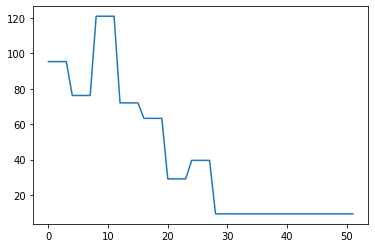

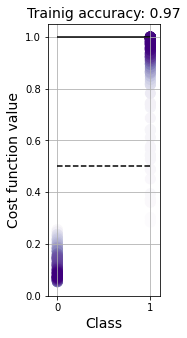

In [32]:
n_instances = 300
regions = [(0, 1/4), (1/4, 2)]
# regions = [(0, 1/3), (1/2, 2/3), (2/3, 1)]
# regions = [0, 1/4, 2/4, 3/4, 1]
# regions = [0, 1/5, 2/5, 3/5, 4/5, 1]

n_classes = len(regions)
class_labels = [i for i in range(n_classes)]
intervals = [(i / n_classes, (i + 1) / n_classes) for i in range(0, n_classes)]

ham1 = random_hermitian(1)
ham2 = random_hermitian(1)

alphas = []
labels = []
dm_originals = []

for i in range(n_instances):
    
    label = random.sample(class_labels, 1)[0]
    labels.append(label)
    alpha = random.uniform(regions[label][0], regions[label][1])
    alphas.append(alpha)
    
    hamiltonian = alpha*ham1 + (1 - alpha)*ham2
    
    state_vector = eigh(hamiltonian)[1][:,0]
    density_matrix = outer(state_vector.conj(), state_vector)
    dm_originals.append(density_matrix)
    
    
method = 'BFGS'

start_time = time.time()
f_values, parameters, optimization_result = classify(dm_originals, labels, method)
print('Completed in', time.time() - start_time)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()


unitary = su2(parameters)
predictions = []
for i in range(n_instances):
    
    density_matrix = unitary.conj().T.dot(dm_originals[i]).dot(unitary)

    prediction = abs(trace(dot(density_matrix, obs)))**2
#     prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
    predictions.append(prediction)
    

ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances):
    ls[labels[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions[i] < intervals[j][1]) and (labels[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances):
    for j in range(n_classes):
        if labels[i] == j:
            predictions_plot[j].append(predictions[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Trainig accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()


# pp = []
# for p in predictions_plot:
#     pp = pp + p
# x = np.array([0]*len(pp))
# y = np.array(pp)
# c = gaussian_kde(pp)(pp)
# idx = c.argsort()
# x, y, c = x[idx], y[idx], c[idx]
# plt.scatter(x, y, c=c, cmap=cmap, s=100)
# for i in range(n_classes - 1):
#     plt.hlines(y=intervals[i][1], xmin=-0.1, xmax=0.1, color='black', linestyle='dashed')
# plt.hlines(y=1, xmin=-0.1, xmax=0.1, color='black', linestyle='solid')      
# plt.ylabel('Cost function value', fontsize=14)
# plt.xticks([0], [0])
# plt.grid()
# plt.show()

#### Classification accuracy

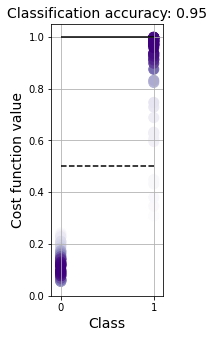

In [37]:
n_instances_test = 100

labels_test = []
alphas_test = []
dm_originals_test = []

for i in range(n_instances_test):
    
    label = random.sample(class_labels, 1)[0]
    labels_test.append(label)
    alpha = random.uniform(regions[label][0], regions[label][1])
    alphas_test.append(alpha)
    
    hamiltonian = alpha*ham1 + (1 - alpha)*ham2
    
    state_vector = eigh(hamiltonian)[1][:,0]
    density_matrix = outer(state_vector.conj(), state_vector)
    dm_originals_test.append(density_matrix)


unitary = su2(parameters)
predictions_test = []
for i in range(n_instances_test):
    
    density_matrix = unitary.conj().T.dot(dm_originals_test[i]).dot(unitary)

    prediction = abs(trace(dot(density_matrix, obs)))**2
#     prediction = (trace(dot(density_matrix, obs)) + 1).real /2
    predictions_test.append(prediction)
    
    
ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances_test):
    ls[labels_test[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions_test[i] < intervals[j][1]) and (labels_test[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances_test):
    for j in range(n_classes):
        if labels_test[i] == j:
            predictions_plot[j].append(predictions_test[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Classification accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()

# V1-1: channel classification of with random $\alpha_1$ and $\alpha_2$ such that $\alpha_1 \leq \alpha_c < \alpha_2 $. 

probe state: $\vert + \rangle$

ansatz: SU(2)

# Notes

Binary training accuracy is ideal.

Works only for $\alpha_c = 3/4$

The $P_0$ observable works not.

In [55]:
# obs = P0
obs = Z

def classify(dm_originals, labels, method, x0=None):
    
    f_values = []
    
    L = len(labels)
    n_pars = 3
    
    def fun(x):
        
        predictions = []
        for i in range(L):
            
            unitary = su2(x)
            density_matrix = unitary.conj().T.dot(dm_originals[i]).dot(unitary)
            
#             prediction = abs(trace(dot(density_matrix, obs)))**2
            prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
            predictions.append(prediction)
    
        f = loglike_cost(labels, predictions)
#         f = abs_dist(labels, predictions)
#         f = least_squares_cost(labels, predictions)
        f_values.append(f)
    
        return f
        
    if x0 is None:
        x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)]
    optimization_result = minimize(fun=fun, x0=x0, method=method)
    
    parameters = optimization_result.x
    
    return f_values, parameters, optimization_result

#### Training accuracy

Completed in 0.3488125801086426


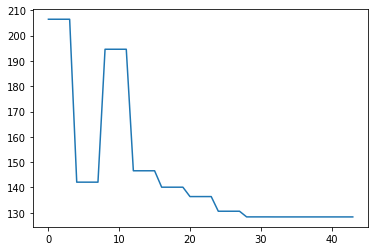

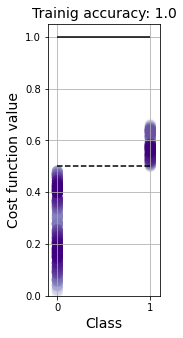

In [56]:
n_instances = 300
regions = [(0, 3/4), (3/4, 1)]
# regions = [0, 1/3, 2/3, 1]
# regions = [0, 1/4, 2/4, 3/4, 1]
# regions = [0, 1/5, 2/5, 3/5, 4/5, 1]

n_classes = len(regions)
class_labels = [i for i in range(n_classes)]
intervals = [(i / n_classes, (i + 1) / n_classes) for i in range(0, n_classes)]

alphas = []
labels = []
dm_originals = []

for i in range(n_instances):
    
    label = random.sample(class_labels, 1)[0]
    labels.append(label)
    alpha = random.uniform(regions[label][0], regions[label][1])
    alphas.append(alpha)
    
    state_vector = np.array([1, 1]) / sqrt(2)
    density_matrix = outer(state_vector, state_vector.conj().T)
    density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_originals.append(density_matrix)
    
    
method = 'BFGS'

start_time = time.time()
f_values, parameters, optimization_result = classify(dm_originals, labels, method)
print('Completed in', time.time() - start_time)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()


unitary = su2(parameters)
predictions = []
for i in range(n_instances):
    
    density_matrix = unitary.conj().T.dot(dm_originals[i]).dot(unitary)

#     prediction = abs(trace(dot(density_matrix, obs)))**2
    prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
    predictions.append(prediction)
    

ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances):
    ls[labels[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions[i] < intervals[j][1]) and (labels[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances):
    for j in range(n_classes):
        if labels[i] == j:
            predictions_plot[j].append(predictions[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Trainig accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()

#### Classification accuracy

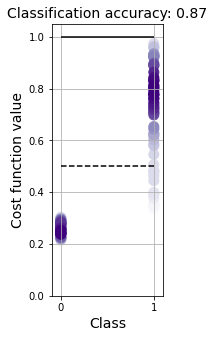

In [45]:
n_instances_test = 100

labels_test = []
alphas_test = []
dm_originals_test = []

for i in range(n_instances_test):
    
    label = random.sample(class_labels, 1)[0]
    labels_test.append(label)
    alpha = random.uniform(regions[label][0], regions[label][1])
    alphas_test.append(alpha)
    
    state_vector = np.array([1, 1]) / sqrt(2)
    density_matrix = outer(state_vector, state_vector.conj().T)
    density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_originals_test.append(density_matrix)


unitary = su2(parameters)
predictions_test = []
for i in range(n_instances_test):
    
    density_matrix = unitary.conj().T.dot(dm_originals_test[i]).dot(unitary)

#     prediction = abs(trace(dot(density_matrix, obs)))**2
    prediction = (trace(dot(density_matrix, obs)) + 1).real /2
    predictions_test.append(prediction)
    
    
ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances_test):
    ls[labels_test[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions_test[i] < intervals[j][1]) and (labels_test[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances_test):
    for j in range(n_classes):
        if labels_test[i] == j:
            predictions_plot[j].append(predictions_test[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Classification accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()

# V1-2: channel classification with random fixed $\alpha_1$ and $\alpha_2$
probe state: random

input: only original states

ansatz: SU(2)

# Notes

Works not.

In [46]:
# obs = P0
obs = Z

def classify(dm_originals, labels, method, x0=None):
    
    f_values = []
    
    L = len(labels)
    n_pars = 3
    
    def fun(x):
        
        predictions = []
        for i in range(L):
            
            unitary = su2(x)
            density_matrix = unitary.conj().T.dot(dm_originals[i]).dot(unitary)
            
#             prediction = abs(trace(dot(density_matrix, obs)))**2
            prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
            predictions.append(prediction)
    
        f = loglike_cost(labels, predictions)
#         f = abs_dist(labels, predictions)
#         f = least_squares_cost(labels, predictions)
        f_values.append(f)
    
        return f
        
    if x0 is None:
        x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)]
    optimization_result = minimize(fun=fun, x0=x0, method=method)
    
    parameters = optimization_result.x
    
    return f_values, parameters, optimization_result

#### Training accuracy

Completed in 0.6424915790557861


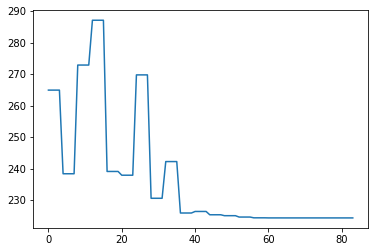

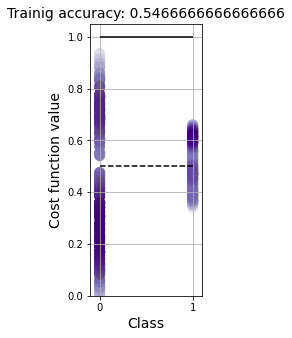

In [47]:
n_instances = 300

label_alpha_pairs = [(0, 0), (1, 1)]
class_labels = [i[0] for i in label_alpha_pairs]
n_classes = len(label_alpha_pairs)
intervals = [(i / n_classes, (i + 1) / n_classes) for i in range(0, n_classes)]

alphas = []
labels = []
dm_originals = []

for i in range(n_instances):
    
    pair = random.sample(label_alpha_pairs, 1)[0]
    label = pair[0]
    alpha = pair[1]
    labels.append(label)
    alphas.append(alpha)
    
    state_vector = np.array(qp.rand_ket_haar(2))
#     state_vector = np.array([1, 1]) / sqrt(2)
    density_matrix = outer(state_vector, state_vector.conj().T)
    density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_originals.append(density_matrix)
    
    
method = 'BFGS'

start_time = time.time()
f_values, parameters, optimization_result = classify(dm_originals, labels, method)
print('Completed in', time.time() - start_time)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()


unitary = su2(parameters)
predictions = []
for i in range(n_instances):
    
    density_matrix = unitary.conj().T.dot(dm_originals[i]).dot(unitary)

#     prediction = abs(trace(dot(density_matrix, obs)))**2
    prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
    predictions.append(prediction)
    

ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances):
    ls[labels[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions[i] < intervals[j][1]) and (labels[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances):
    for j in range(n_classes):
        if labels[i] == j:
            predictions_plot[j].append(predictions[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Trainig accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()


# pp = []
# for p in predictions_plot:
#     pp = pp + p
# x = np.array([0]*len(pp))
# y = np.array(pp)
# c = gaussian_kde(pp)(pp)
# idx = c.argsort()
# x, y, c = x[idx], y[idx], c[idx]
# plt.scatter(x, y, c=c, cmap=cmap, s=100)
# for i in range(n_classes - 1):
#     plt.hlines(y=intervals_red[i][1], xmin=-0.1, xmax=0.1, color='black', linestyle='dashed')
# plt.hlines(y=1, xmin=-0.1, xmax=0.1, color='black', linestyle='solid')      
# plt.ylabel('Cost function value', fontsize=14)
# plt.xticks([0], [0])
# plt.grid()
# plt.show()

# V2-1: channel classification of with random $\alpha_1$ and $\alpha_2$ such that $\alpha_1 \leqslant \alpha_c < \alpha_2 $. 
probe state: $\vert + \rangle$

input: original and acted states

ansatz: $SU(2) \otimes SU(2)$

# Notes

Works well for $\alpha_c = 3/4$. $SU(4)$ ansatz gives no advantage.

In [26]:
# obs = kron(P0, P0)
obs = kron(Z, Z)

def classify(dm_originals, dm_noiseds, labels, method, x0=None):
    
    f_values = []
    
    L = len(labels)
    n_pars = 15
    
    def fun(x):
        
        predictions = []
        for i in range(L):
            
            unitary = su4(x)
#             unitary = kron(su2(x[:3]), su2(x[3:]))
            density_matrix = kron(dm_originals[i], dm_noiseds[i])
            density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)
            
#             prediction = abs(trace(dot(density_matrix, obs)))**2
            prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
            predictions.append(prediction)
    
#         f = loglike_cost(labels, predictions)
#         f = abs_dist(labels, predictions)
        f = least_squares_cost(labels, predictions)
        f_values.append(f)
    
        return f
        
    if x0 is None:
        x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)]
    optimization_result = minimize(fun=fun, x0=x0, method=method)
    
    parameters = optimization_result.x
    
    return f_values, parameters, optimization_result

#### Training accuracy

Completed in 15.641833066940308


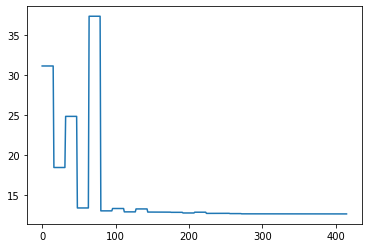

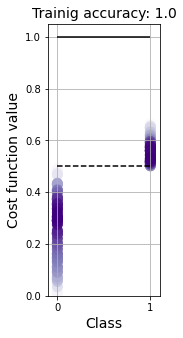

In [29]:
n_instances = 100
regions = [(0.0, 0.75), (0.75, 1.0)]
# regions = [(0, 3/4), (3/4, 1)]
# regions = [(0, 1/3), (1/3, 2/3), (2/3, 1)]
# regions = [0, 1/4, 2/4, 3/4, 1]
# regions = [0, 1/5, 2/5, 3/5, 4/5, 1]

n_classes = len(regions)
class_labels = [i for i in range(n_classes)]
intervals = [(i / n_classes, (i + 1) / n_classes) for i in range(0, n_classes)]

alphas = []
labels = []
dm_originals = []
dm_noiseds = []

for i in range(n_instances):
    
    label = random.sample(class_labels, 1)[0]
    labels.append(label)
    alpha = random.uniform(regions[label][0], regions[label][1])
    alphas.append(alpha)

    state_vector = np.array([1, 1])/sqrt(2)
    density_matrix = outer(state_vector, state_vector.conj().T)
    dm_originals.append(density_matrix)
    density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_noiseds.append(density_matrix)
    
    
method = 'BFGS'

start_time = time.time()
f_values, parameters, optimization_result = classify(dm_originals, dm_noiseds, labels, method)
print('Completed in', time.time() - start_time)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()


unitary = su4(parameters)    
# unitary = kron(su2(parameters[:3]), su2(parameters[3:]))
predictions = []
for i in range(n_instances):
    
    density_matrix = kron(dm_originals[i], dm_noiseds[i])
    density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)

#     prediction = abs(trace(dot(density_matrix, obs)))**2
    prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
    predictions.append(prediction)
    

ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances):
    ls[labels[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions[i] < intervals[j][1]) and (labels[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances):
    for j in range(n_classes):
        if labels[i] == j:
            predictions_plot[j].append(predictions[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Trainig accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()

#### Classification accuracy

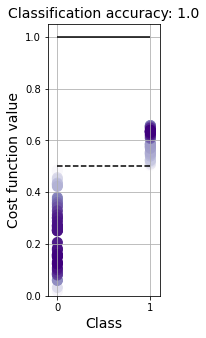

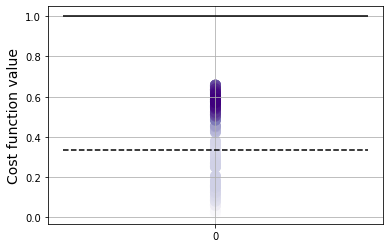

In [36]:
n_instances_test = 100

labels_test = []
alphas_test = []
dm_originals_test = []
dm_noiseds_test = []

for i in range(n_instances_test):
    
    label = random.sample(class_labels, 1)[0]
    labels_test.append(label)
    alpha = random.uniform(regions[label][0], regions[label][1])
    alphas_test.append(alpha)

    state_vector = np.array([1, 1])/sqrt(2)
    density_matrix = outer(state_vector, state_vector.conj().T)
    dm_originals_test.append(density_matrix)
    density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_noiseds_test.append(density_matrix)
    

unitary = su4(parameters)    
# unitary = kron(su2(parameters[:3]), su2(parameters[3:]))
predictions_test = []
for i in range(n_instances_test):
    
    density_matrix = kron(dm_originals_test[i], dm_noiseds_test[i])
    density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)

#     prediction = abs(trace(dot(density_matrix, obs)))**2
    prediction = (trace(dot(density_matrix, obs)) + 1).real /2
    predictions_test.append(prediction)
    
    
ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances_test):
    ls[labels_test[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions_test[i] < intervals[j][1]) and (labels_test[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances_test):
    for j in range(n_classes):
        if labels_test[i] == j:
            predictions_plot[j].append(predictions_test[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Classification accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()


pp = []
for p in predictions_plot:
    pp = pp + p
x = np.array([0]*len(pp))
y = np.array(pp)
c = gaussian_kde(pp)(pp)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals_red[i][1], xmin=-0.1, xmax=0.1, color='black', linestyle='dashed')
plt.hlines(y=1, xmin=-0.1, xmax=0.1, color='black', linestyle='solid')      
plt.ylabel('Cost function value', fontsize=14)
plt.xticks([0], [0])
plt.grid()
plt.show()

# V2-2: channel classification with random fixed $\alpha_1$ and $\alpha_2$
probe state: random

input: original and acted states

ansatz: $SU(2) \otimes SU(2)$

# Notes

Works ideally for $\alpha=3/4$. 

$SU(4)$ ansatz does not help.

In [10]:
# obs = kron(P0, P0)
obs = kron(Z, Z)

def classify(dm_originals, dm_noiseds, labels, method, x0=None):
    
    f_values = []
    
    L = len(labels)
    n_pars = 6
    
    def fun(x):
        
        predictions = []
        for i in range(L):
            
            unitary = kron(su2(x[:3]), su2(x[3:]))
#             unitary = su4(x)
            density_matrix = kron(dm_originals[i], dm_noiseds[i])
            density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)
            
#             prediction = abs(trace(dot(density_matrix, obs)))**2
            prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
            predictions.append(prediction)
    
        f = loglike_cost(labels, predictions)
#         f = abs_dist(labels, predictions)
#         f = least_squares_cost(labels, predictions)
        f_values.append(f)
    
        return f
        
    if x0 is None:
        x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)]
    optimization_result = minimize(fun=fun, x0=x0, method=method)
    
    parameters = optimization_result.x
    
    return f_values, parameters, optimization_result

#### Training accuracy

Completed in 0.9825649261474609


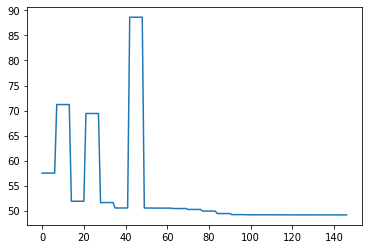

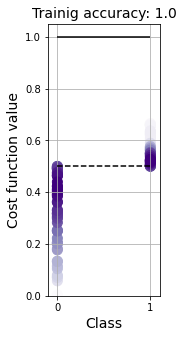

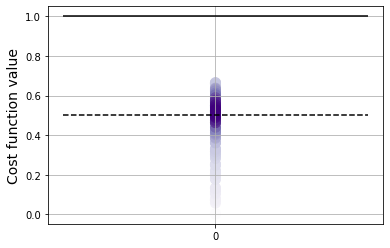

In [18]:
n_instances = 100

label_alpha_pairs = [(0, 0.0), (1, 1.0)]
class_labels = [i[0] for i in label_alpha_pairs]
n_classes = len(label_alpha_pairs)
intervals = [(i / n_classes, (i + 1) / n_classes) for i in range(0, n_classes)]

alphas = []
labels = []
dm_originals = []
dm_noiseds = []

for i in range(n_instances):
    
    pair = random.sample(label_alpha_pairs, 1)[0]
    label = pair[0]
    alpha = pair[1]
    labels.append(label)
    alphas.append(alpha)
    
    state_vector = np.array(qp.rand_ket_haar(2))
    density_matrix = outer(state_vector, state_vector.conj().T)
    dm_originals.append(density_matrix)
    density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_noiseds.append(density_matrix)
    
    
method = 'BFGS'

start_time = time.time()
f_values, parameters, optimization_result = classify(dm_originals, dm_noiseds, labels, method)
print('Completed in', time.time() - start_time)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()


unitary = kron(su2(parameters[:3]), su2(parameters[3:]))
# unitary = su4(parameters)
predictions = []
for i in range(n_instances):
    
    density_matrix = kron(dm_originals[i], dm_noiseds[i])
    density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)

#     prediction = abs(trace(dot(density_matrix, obs)))**2
    prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
    predictions.append(prediction)
    

ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances):
    ls[labels[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions[i] < intervals[j][1]) and (labels[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances):
    for j in range(n_classes):
        if labels[i] == j:
            predictions_plot[j].append(predictions[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Trainig accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()


pp = []
for p in predictions_plot:
    pp = pp + p    
x = np.array([0]*len(pp))
y = np.array(pp)
c = gaussian_kde(pp)(pp)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=-0.1, xmax=0.1, color='black', linestyle='dashed')
plt.hlines(y=1, xmin=-0.1, xmax=0.1, color='black', linestyle='solid')      
plt.ylabel('Cost function value', fontsize=14)
plt.xticks([0], [0])
plt.grid()
plt.show()

#### Classification accuracy

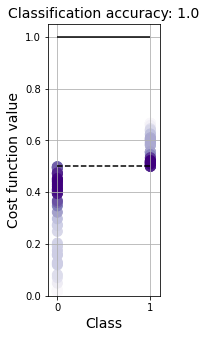

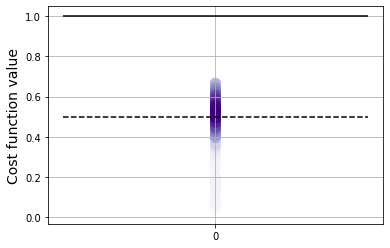

In [22]:
n_instances_test = 100

labels_test = []
alphas_test = []
dm_originals_test = []
dm_noiseds_test = []

for i in range(n_instances_test):
    
    pair = random.sample(label_alpha_pairs, 1)[0]
    label = pair[0]
    alpha = pair[1]
    labels_test.append(label)
    alphas_test.append(alpha)
    
    state_vector = np.array(qp.rand_ket_haar(2))
#     state_vector = np.array([1, 1]) / sqrt(2)
    density_matrix = outer(state_vector, state_vector.conj())
    dm_originals_test.append(density_matrix)
    density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_noiseds_test.append(density_matrix)


unitary = kron(su2(parameters[:3]), su2(parameters[3:]))
predictions_test = []
for i in range(n_instances_test):
    
    density_matrix = kron(dm_originals_test[i], dm_noiseds_test[i])
    density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)

#     prediction = abs(trace(dot(density_matrix, obs)))**2
    prediction = (trace(dot(density_matrix, obs)) + 1).real /2
    predictions_test.append(prediction)
    
    
ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances_test):
    ls[labels_test[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions_test[i] < intervals[j][1]) and (labels_test[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances_test):
    for j in range(n_classes):
        if labels_test[i] == j:
            predictions_plot[j].append(predictions_test[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Classification accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()


pp = []
for p in predictions_plot:
    pp = pp + p
x = np.array([0]*len(pp))
y = np.array(pp)
c = gaussian_kde(pp)(pp)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=-0.1, xmax=0.1, color='black', linestyle='dashed')
plt.hlines(y=1, xmin=-0.1, xmax=0.1, color='black', linestyle='solid')      
plt.ylabel('Cost function value', fontsize=14)
plt.xticks([0], [0])
plt.grid()
plt.show()

# V3-2: channel classification with random fixed $\alpha_1$ and $\alpha_2$

probe state: random

input: original and acted states

ansatz: SWAP-test + $SU(2) \otimes SU(2)$

In [169]:
unitary = reduce(kron, [H, I, I])
unitary = cswap.dot(unitary)
unitary = reduce(kron, [H, I, I]).dot(unitary)

sv1 = np.array(qp.rand_ket_haar(2))
dm1 = np.outer(sv1, sv1.conj().T)
sv2 = np.array(qp.rand_ket_haar(2))
dm2 = np.outer(sv2, sv2.conj().T)

density_matrix = reduce(kron, [P0, dm1, dm2])
density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)

obs = reduce(kron, [P0, I, I])

prediction = (trace(dot(density_matrix, obs)).real)*2 - 1
tr = trace(dm1.dot(dm2)).real
ol = (abs(sv1.conj().T.dot(sv2))**2)[0,0]
print(prediction, tr, ol)

0.8369312739996575 0.8369312739996588 0.8369312739996588


In [189]:
x = [random.uniform(-2*pi, 2*pi) for i in range(6)]

unitary = reduce(kron, [H, I, I])
unitary = cswap.dot(unitary)
unitary = reduce(kron, [H, su2(x[:3]), su2(x[3:])]).dot(unitary)

density_matrix = reduce(kron, [P0, dm_originals[i], dm_noiseds[i]])
density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)

obs = reduce(kron, [P0, I, I])

prediction = (trace(dot(density_matrix, obs)).real)*2 - 1

dm1 = su2(x[:3]).dot(dm_originals[i]).dot(su2(x[:3]).conj().T)
dm2 = su2(x[3:]).dot(dm_noiseds[i]).dot(su2(x[3:]).conj().T)
tr = trace(dm1.dot(dm2)).real
print(prediction, tr)

0.5483563666644451 0.5968249094039383


In [190]:
x = [random.uniform(-2*pi, 2*pi) for i in range(6)]

unitary = reduce(kron, [H, I, I])
unitary = cswap.dot(unitary)
unitary = reduce(kron, [H, I, I]).dot(unitary)

dm1 = su2(x[:3]).dot(dm_originals[i]).dot(su2(x[:3]).conj().T)
dm2 = su2(x[3:]).dot(dm_noiseds[i]).dot(su2(x[3:]).conj().T)

density_matrix = reduce(kron, [P0, dm1, dm2])
density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)

obs = reduce(kron, [P0, I, I])

prediction = (trace(dot(density_matrix, obs)).real)*2 - 1

tr = trace(dm1.dot(dm2)).real
print(prediction, tr)

0.43088956349190655 0.43088956349190694


In [216]:
# obs = kron(P0, P0)
obs = reduce(kron, [P0, I, I])

def classify(dm_originals, dm_noiseds, labels, method, x0=None):
    
    f_values = []
    
    L = len(labels)
    n_pars = 6
    
    def fun(x):
        
        predictions = []
        for i in range(L):
            
            unitary = reduce(kron, [H, I, I])
            unitary = cswap.dot(unitary)
            unitary = reduce(kron, [H, I, I]).dot(unitary)
            
            dm1 = su2(x[:3]).dot(dm_originals[i]).dot(su2(x[:3]).conj().T)
            dm2 = su2(x[3:]).dot(dm_noiseds[i]).dot(su2(x[3:]).conj().T)
            density_matrix = reduce(kron, [P0, dm1, dm2])
            density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)
            
#             prediction = abs(trace(dot(density_matrix, obs)))**2
#             prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
            prediction = (trace(dot(density_matrix, obs)).real)*2 - 1
            predictions.append(prediction)
    
        f = loglike_cost(labels, predictions)
#         f = abs_dist(labels, predictions)
#         f = least_squares_cost(labels, predictions)
        f_values.append(f)
    
        return f
        
    if x0 is None:
        x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)]
    optimization_result = minimize(fun=fun, x0=x0, method=method)
    
    parameters = optimization_result.x
    
    return f_values, parameters, optimization_result

Completed in 4.1533424854278564


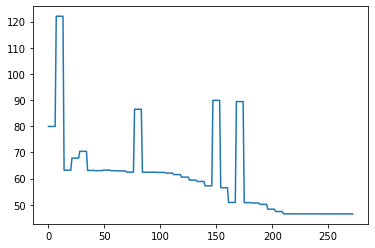

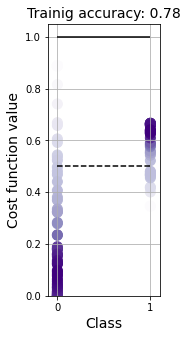

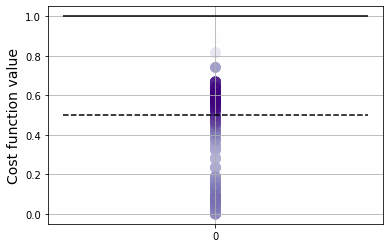

In [217]:
n_instances = 100

label_alpha_pairs = [(0, 0), (1, 1.0)]
class_labels = [i[0] for i in label_alpha_pairs]
n_classes = len(label_alpha_pairs)
intervals = [(i / n_classes, (i + 1) / n_classes) for i in range(0, n_classes)]

alphas = []
labels = []
dm_originals = []
dm_noiseds = []

for i in range(n_instances):
    
    pair = random.sample(label_alpha_pairs, 1)[0]
    label = pair[0]
    alpha = pair[1]
    labels.append(label)
    alphas.append(alpha)
    
    state_vector = np.array(qp.rand_ket_haar(2))
    density_matrix = outer(state_vector, state_vector.conj().T)
    dm_originals.append(density_matrix)
    density_matrix = local_depolarizing_channel(1, density_matrix, alpha, 0)
    dm_noiseds.append(density_matrix)
    
    
method = 'BFGS'

start_time = time.time()
f_values, parameters, optimization_result = classify(dm_originals, dm_noiseds, labels, method)
print('Completed in', time.time() - start_time)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()


unitary = reduce(kron, [H, I, I])
unitary = cswap.dot(unitary)
unitary = reduce(kron, [H, I, I]).dot(unitary)
predictions = []
for i in range(n_instances):
    
    dm1 = su2(parameters[:3]).dot(dm_originals[i]).dot(su2(parameters[:3]).conj().T)
    dm2 = su2(parameters[3:]).dot(dm_noiseds[i]).dot(su2(parameters[3:]).conj().T)
    density_matrix = reduce(kron, [P0, dm1, dm2])
    density_matrix = unitary.conj().T.dot(density_matrix).dot(unitary)

#     prediction = abs(trace(dot(density_matrix, obs)))**2
#     prediction = (trace(dot(density_matrix, obs)).real + 1) / 2
    prediction = (trace(dot(density_matrix, obs)).real)*2 - 1
    predictions.append(prediction)
    

ls = [0] * n_classes
ps = [0] * n_classes
for i in range(n_instances):
    ls[labels[i]] += 1
    for j in range(n_classes):
        if (intervals[j][0] <= predictions[i] < intervals[j][1]) and (labels[i] == j):
            ps[j] += 1
acc = sum(ps)/ sum(ls)


predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_instances):
    for j in range(n_classes):
        if labels[i] == j:
            predictions_plot[j].append(predictions[i])

cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('partBlues', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.hlines(y=1, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='solid')      
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Trainig accuracy: ' + str(acc), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
plt.ylim(ymin=0, ymax=1.05)
plt.grid()
plt.show()


pp = []
for p in predictions_plot:
    pp = pp + p    
x = np.array([0]*len(pp))
y = np.array(pp)
c = gaussian_kde(pp)(pp)
idx = c.argsort()
x, y, c = x[idx], y[idx], c[idx]
plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=intervals[i][1], xmin=-0.1, xmax=0.1, color='black', linestyle='dashed')
plt.hlines(y=1, xmin=-0.1, xmax=0.1, color='black', linestyle='solid')      
plt.ylabel('Cost function value', fontsize=14)
plt.xticks([0], [0])
plt.grid()
plt.show()